In [20]:
import xml.etree.ElementTree as ET
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import gaussian_kde

tree = ET.parse('annotations_reformatted.xml')
videos = tree.getroot()

[Text(0, 0, '1172'), Text(0, 0, '245')]

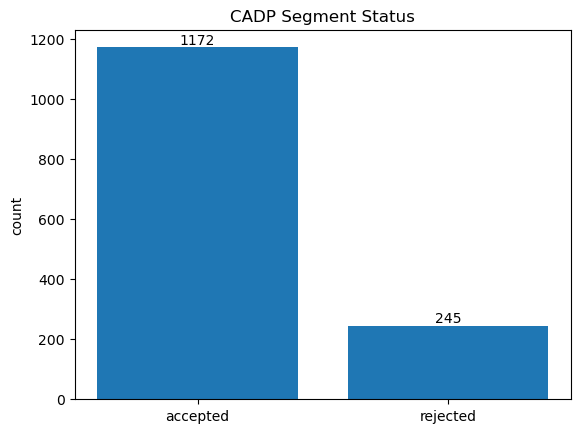

In [3]:
statuses = {'accepted':0, 'rejected':0}
for video in videos.iter('video'):
    status = video.find('status').text
    statuses[status] += 1
fig, ax = plt.subplots()
bar_container = ax.bar(list(statuses.keys()), list(statuses.values()))
ax.set(title='CADP Segment Status', ylabel='count')
ax.bar_label(bar_container)

In [4]:
durations = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        durations.append(float(video.find('length').text) / 30.0)

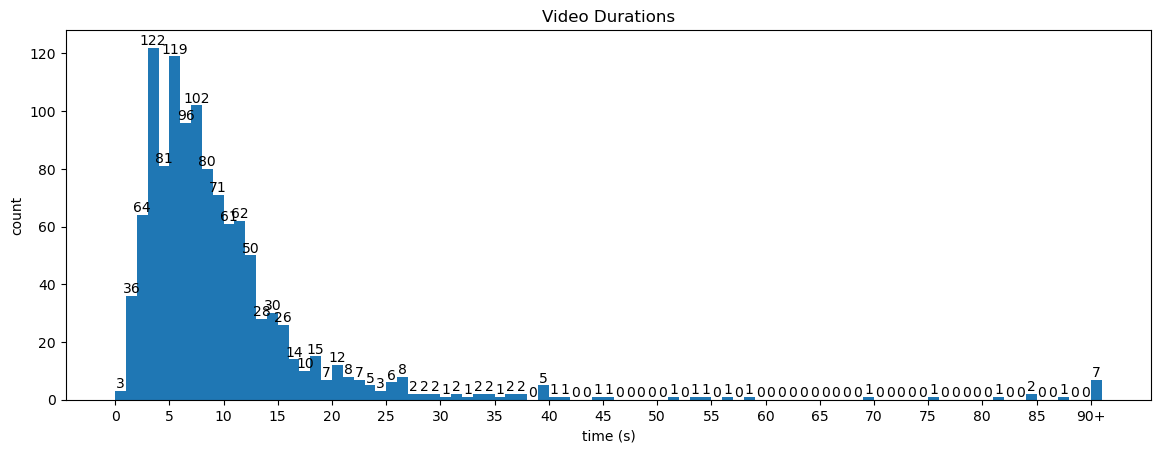

In [5]:
fig, ax = plt.subplots()
bins = range(0,92)
_, _, bars = ax.hist(np.clip(durations, bins[0], bins[-1]), bins=bins)
ax.set(title='Video Durations', xlabel='time (s)', ylabel='count')
ax.bar_label(bars)
ticks = np.arange(0,91,5)
ax.set_xticks(ticks)
xlabels = ticks.astype(str)
xlabels[-1] += '+'
ax.set_xticklabels(xlabels)
fig.set_figwidth(14)
plt.show(fig)

In [6]:
resolutions = {}
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        width = video.find('width').text
        height = video.find('height').text
        res = (int(width), int(height))
        if res not in resolutions:
            label = width + 'x' + height
            resolutions[res] = {'label':label, 'count':1}
        else:
            resolutions[res]['count'] += 1

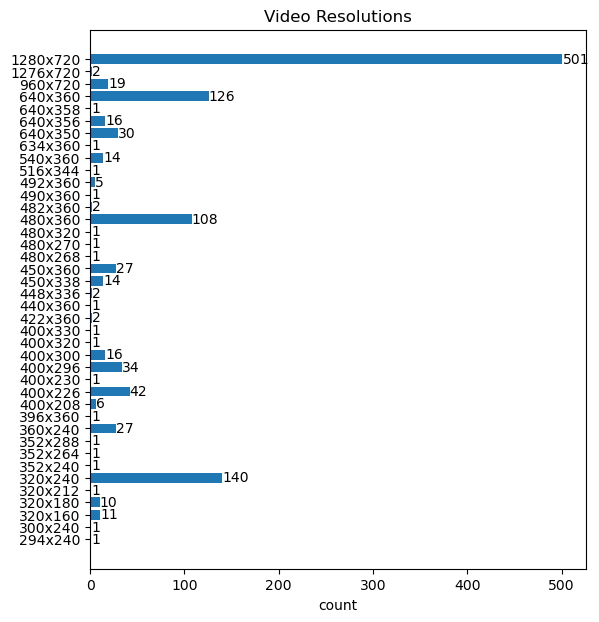

In [7]:
fig, ax = plt.subplots()
sorteddict = sorted(resolutions.items())
labels = [None] * len(sorteddict)
counts = [None] * len(sorteddict)
for i in range(len(sorteddict)):
    labels[i] = sorteddict[i][1]['label']
    counts[i] = sorteddict[i][1]['count']
bars = ax.barh(labels, counts)
ax.set(title='Video Resolutions', xlabel='count')
ax.bar_label(bars)
fig.set_figheight(7)
plt.show(fig)

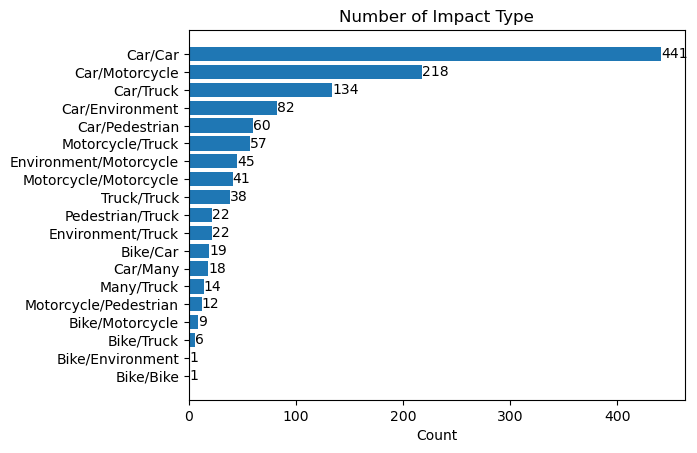

1240


In [8]:
elements = {}
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        for track in video.find('tracks').iter('track'):
            el1 = track.get('Element1')
            el2 = track.get('Element2')
            els = '/'.join(sorted([el1, el2]))
            if els not in elements:
                elements[els] = 1
            else:
                elements[els] += 1
fig, ax = plt.subplots()
sorteddict = {k: v for k, v in sorted(elements.items(), key=lambda item: item[1])}
bars = ax.barh(list(sorteddict.keys()), list(sorteddict.values()))
ax.set(title='Number of Impact Type', xlabel='Count')
ax.bar_label(bars)
plt.show(fig)
print(sum(sorteddict.values()))

{'1': 1112, '2': 55, '3': 3, '5': 1, '4': 1}


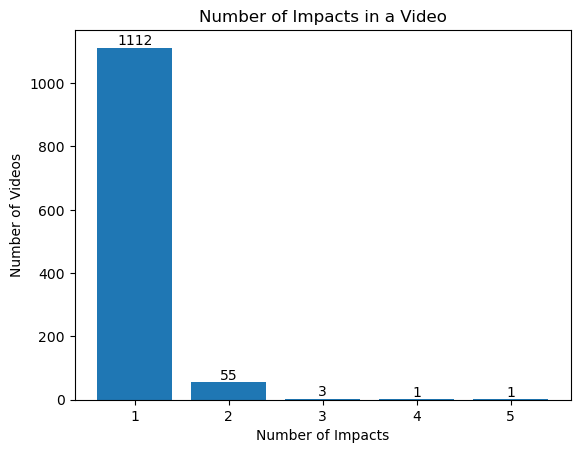

In [9]:
numtracks_list = {}
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        numtracks = video.find('numtracks').text
        if numtracks not in numtracks_list:
            numtracks_list[numtracks] = 1
        else:
            numtracks_list[numtracks] += 1
print(numtracks_list)
fig, ax = plt.subplots()
sorteddict = {k: v for k, v in sorted(numtracks_list.items(), key=lambda item: item[0])}
bars = ax.bar(list(sorteddict.keys()), list(sorteddict.values()))
ax.set(title='Number of Impacts in a Video', xlabel='Number of Impacts', ylabel='Number of Videos')
ax.bar_label(bars)
plt.show(fig)

In [10]:
crash_starts = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        tracks = video.find('tracks')
        starts = []
        for track in tracks.iter('track'):
            starts.append(int(track[0].attrib.get('frame')))
        crash_starts.append(min(starts))

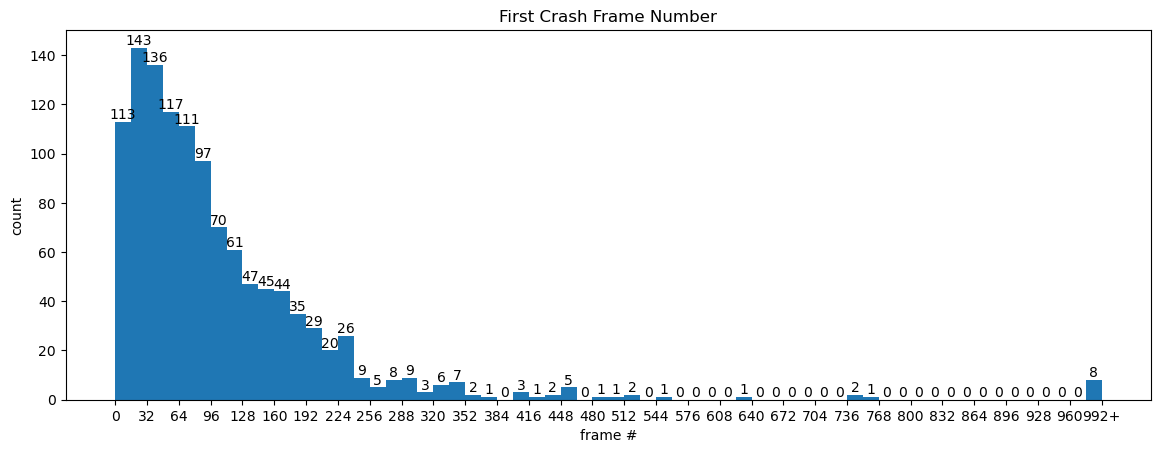

In [11]:
plotmax = 1000
fig, ax = plt.subplots()
bins = range(0,plotmax+2,16)
_, _, bars = ax.hist(np.clip(crash_starts, bins[0], bins[-1]), bins=bins)
ax.set(title='First Crash Frame Number', xlabel='frame #', ylabel='count')
ax.bar_label(bars)
ticks = np.arange(0,plotmax+1,32)
ax.set_xticks(ticks)
xlabels = ticks.astype(str)
xlabels[-1] += '+'
ax.set_xticklabels(xlabels)
fig.set_figwidth(14)
plt.show(fig)

In [12]:
starts = []
settles = []
ends = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        tracks = video.find('tracks')
        for track in tracks.iter('track'):
            if track.attrib.get('Element1') != track.attrib.get('Element2') != 'Car':
                continue
            starts.append(int(track.attrib.get('start')))
            settles.append(int(track.attrib.get('settled')))
            ends.append(int(track.attrib.get('end')))
            if int(track.attrib.get('settled')) - int(track.attrib.get('start')) > 250:
                print(video.find('name').text)
starts = np.array(starts)
settles = np.array(settles)
ends = np.array(ends)

ALFF5620ljk06.mp4
h8R-AyCY_k402.mp4
w-FeiCXyHBE01.mp4


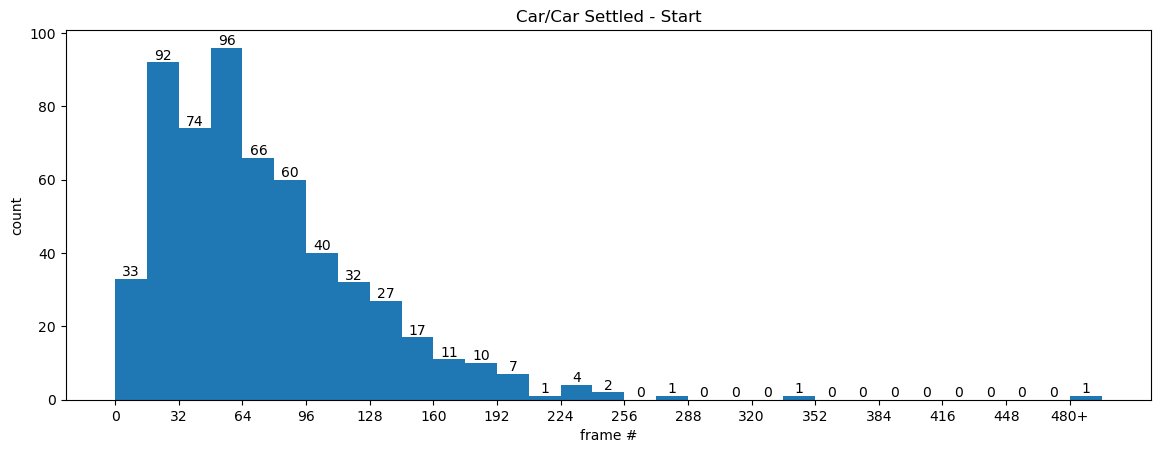

42713


In [13]:
plotmax = 500
fig, ax = plt.subplots()
bins = range(0,plotmax+2,16)
_, _, bars = ax.hist(np.clip(np.subtract(settles, starts), bins[0], bins[-1]), bins=bins)
ax.set(title='Car/Car Settled - Start', xlabel='frame #', ylabel='count')
ax.bar_label(bars)
ticks = np.arange(0,plotmax+1,32)
ax.set_xticks(ticks)
xlabels = ticks.astype(str)
xlabels[-1] += '+'
ax.set_xticklabels(xlabels)
fig.set_figwidth(14)
plt.show(fig)

print(np.sum(np.subtract(settles, starts)))

In [14]:
frame_widths = []
frame_heights = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        tracks = video.find('tracks')
        start = 999999
        for track in tracks.iter('track'):
            width = float(track[0].attrib.get('xbr')) - float(track[0].attrib.get('xtl'))
            height = float(track[0].attrib.get('ybr')) - float(track[0].attrib.get('ytl'))
            frame_widths.append(width)
            frame_heights.append(height)

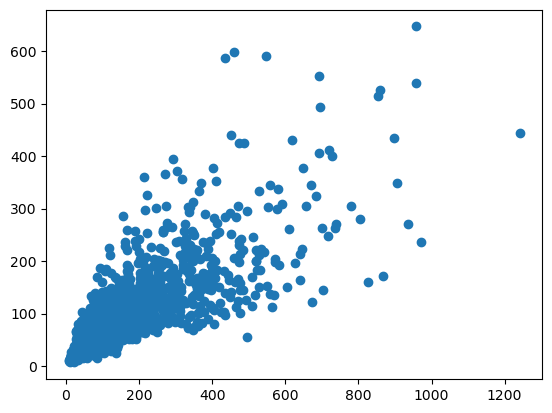

In [15]:
plt.scatter(frame_widths, frame_heights)
plt.show()

In [16]:
start_areas = []
end_areas = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        tracks = video.find('tracks')
        for track in tracks.iter('track'):
            frames = track.findall('frame')
            width = float(frames[0].attrib.get('xbr')) - float(frames[0].attrib.get('xtl'))
            height = float(frames[0].attrib.get('ybr')) - float(frames[0].attrib.get('ytl'))
            start_areas.append(width*height)
            width = float(frames[-1].attrib.get('xbr')) - float(frames[-1].attrib.get('xtl'))
            height = float(frames[-1].attrib.get('ybr')) - float(frames[-1].attrib.get('ytl'))           
            end_areas.append(width*height)

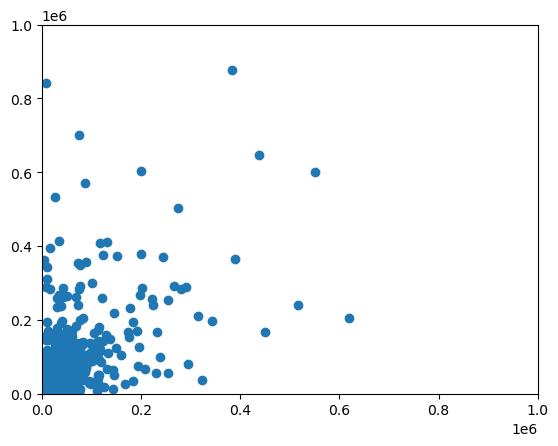

In [17]:
plt.scatter(start_areas, end_areas)
plt.xlim(0,1000000)
plt.ylim(0,1000000)
plt.show()

In [27]:
widths = []
heights = []
for video in videos.iter('video'):
    status = video.find('status').text
    if status == 'accepted':
        tracks = video.find('tracks')
        for track in tracks.iter('track'):
            frames = track.findall('frame')
            for frame in frames:
                widths.append(int(round(float(frame.attrib.get('xbr')))) - int(round(float(frame.attrib.get('xtl')))))
                heights.append(int(round(float(frame.attrib.get('ybr')))) - int(round(float(frame.attrib.get('ytl')))))


In [28]:
# Calculate the point density
xy = np.vstack([widths,heights])
z = gaussian_kde(xy)(xy)

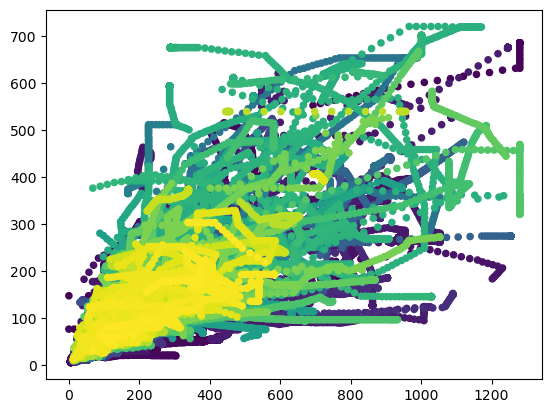

In [33]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
w = np.array(widths)[idx.astype(int)]
h = np.array(heights)[idx.astype(int)]
w, h, z = w[idx], h[idx], z[idx]

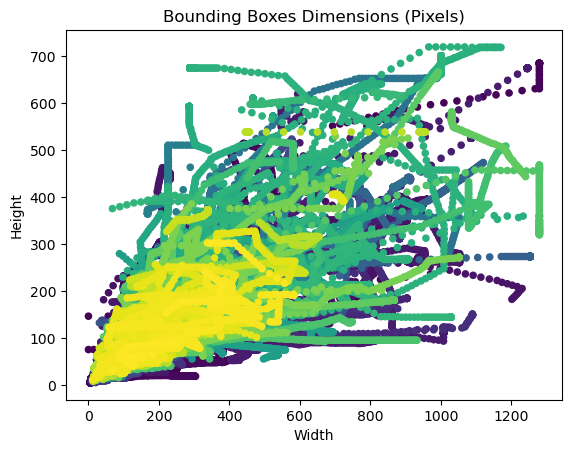

In [49]:
fig, ax = plt.subplots()
ax.scatter(widths, heights, c=z, s=20)
ax.set(title='Bounding Boxes Dimensions (Pixels)', xlabel='Width', ylabel='Height')
plt.show()

In [43]:
widths_pcnt = []
heights_pcnt = []
for video in videos.iter('video'):
    status = video.find('status').text
    _width = float(video.find('width').text)
    _height = float(video.find('height').text)
    if status == 'accepted':
        tracks = video.find('tracks')
        for track in tracks.iter('track'):
            frames = track.findall('frame')
            for frame in frames:
                widths_pcnt.append(int(round(((float(frame.attrib.get('xbr')) - float(frame.attrib.get('xtl'))) / _width) * 100)))
                heights_pcnt.append(int(round(((float(frame.attrib.get('ybr')) - float(frame.attrib.get('ytl'))) / _height) * 100)))

In [44]:
# Calculate the point density
xy = np.vstack([widths_pcnt,heights_pcnt])
z2 = gaussian_kde(xy)(xy)

In [45]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
w2 = np.array(widths_pcnt)[idx.astype(int)]
h2 = np.array(heights_pcnt)[idx.astype(int)]
w2, h2, z2 = w2[idx], h2[idx], z2[idx]

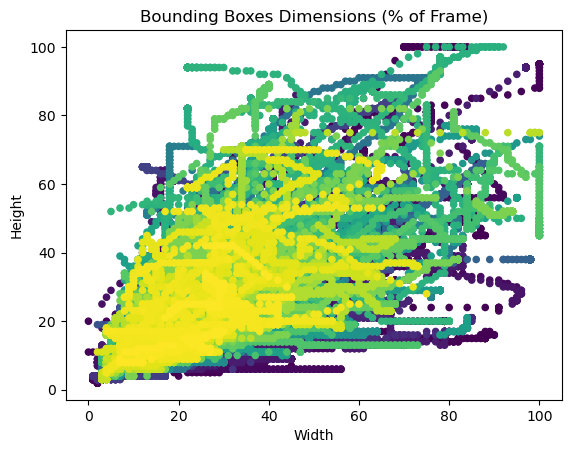

In [48]:
fig, ax = plt.subplots()
ax.scatter(w2, h2, c=z, s=20)
ax.set(title='Bounding Boxes Dimensions (% of Frame)', xlabel='Width', ylabel='Height')
plt.show()